In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sample_rate = 1e6 
N = 500 # number of observations
d= 0.5 # Half Wavelengh 
Nr = 4 # Number of sensors
t = np.arange(N)/sample_rate # time vector

In [3]:
def create_signal(theta_deg, amplitude, f_tone):
    x = (amplitude)*np.exp(2j * np.pi * f_tone * t)
    s = np.exp(-2j * np.pi * d * np.arange (Nr) * np.sin(theta_deg/180*np.pi))
    s = s.reshape(-1, 1) #column vector
    x = x.reshape(1, -1) #row vector
    X = s @ x #create steered signal X (N x Nr)
    return X

In [4]:
theta_deg = 10 # direction of arrival

X1 = create_signal(theta_deg,  1, 0.05e6 )


(500,)


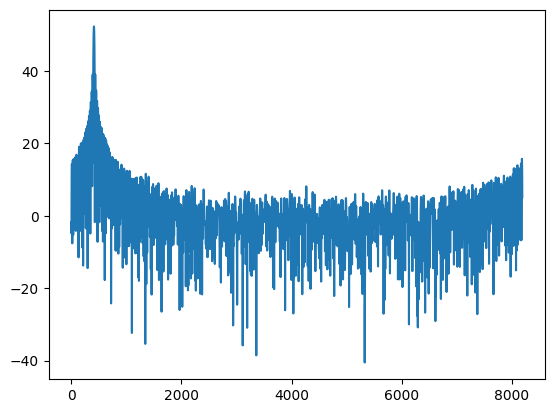

In [5]:
n = np.random.randn(Nr, N) + 1j*np.random.randn(Nr, N)
X = X1 + 0.05*n  # X and n are both NrxN
Xsum = np.sum(X, 0)/Nr
print(Xsum.shape) # 3x10000.  X is now going to be a 2D array, 1D is time and 1D is the spatial dimension
plt.plot(10*np.log10(np.abs(np.fft.fft(Xsum, 8192))**2))
plt.show()

In [6]:
def LSE_RLS(mu, X, D):
    mu_inv = 1/mu
    P = (1/0.002)*np.eye(Nr) #P(0)
    wq = np.ones(Nr) # w(0)
    w_lse = wq
    pk = P[0]
    for k in range(X):
        gk = (mu_inv*pk*X[k]) / (1 + mu_inv*X[k].conj()*pk*X[k])
        pk = mu_inv*P[k-1] - mu_inv*gk*X[k].conj().P[k-1]
        ek = D[k] - w_lse.conj()*X[k]
        w_lse = w_lse + gk*ek.conj()


In [13]:
P = (1/0.002)*np.eye(Nr) #P(0)
mu_inv = 1/.999
gk0 =  mu_inv*(P[0] @ X.T[0]) / 1+mu_inv*(X.conj().T[0].reshape(-1,1) @ P[0].reshape(1,-1) @ X.T[0])
print(gk0)
print(gk0 @ X.conj().T[0].reshape(-1,1) @ P[0])

[993.89519089 -32.70500038j 933.53553841+262.63062136j
 745.51348224+417.41069678j 512.4725478 +466.27211903j]


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 1)